In [9]:
import random
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from datetime import datetime

In [2]:
class DQN(nn.Module):
    def __init__(self, in_states, h1_nodes, out_actions):
        super().__init__()

        self.fc1 = nn.Linear(in_states, h1_nodes)
        self.out = nn.Linear(h1_nodes, out_actions)

    def forward(self, x):
        return self.out(F.relu(self.fc1(x)))

In [3]:
class SumTree():
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1, dtype=np.float32)
        self.data_pointer = 0
    
    def update(self, idx, priority):
        tree_index = idx + self.capacity - 1
        change = priority - self.tree[tree_index]
        self.tree[tree_index] = priority
        while tree_index != 0:
            tree_index = (tree_index - 1) // 2
            self.tree[tree_index] += change
        
    def get_leaf(self, idx):
        parent_index = 0
        while True:
            left_child = 2 * parent_index + 1
            right_child = left_child + 1

            if left_child >= len(self.tree):
                leaf_index = parent_index
                break
            if idx <= self.tree[left_child]:
                parent_index = left_child
            else:
                idx -= self.tree[left_child]
                parent_index = right_child
        data_index = leaf_index - self.capacity + 1
        return data_index, self.tree[leaf_index]
    
    def total_sum(self):
        return self.tree[0]

In [4]:
class PrioritizedReplayMemory():
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha  # alpha = 0.6 (controls how much prioritization is used) 0 = no prioritization, 1 = full prioritization
        self.priorities = SumTree(capacity)
        self.buffer = []
        self.position = 0
        self.max_priority = 1.0
        
    def store(self, state, action, reward, next_state, done, priority):
        experience = (state, action, reward, next_state, done)
        
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.position] = experience
        
        self.priorities.update(self.position, priority ** self.alpha)
        self.max_priority = max(self.max_priority, priority)
        self.position = (self.position + 1) % self.capacity

    def update_priority(self, index, priority):
        self.priorities.update(index, priority ** self.alpha)
        self.max_priority = max(self.max_priority, priority)
    
    def sample(self, batch_size, beta=0.4):
        indices = []
        priorities = []
        experiences = []

        # sample based on priority
        total_priority = self.priorities.total_sum()
        segment_size = total_priority / batch_size

        for i in range(batch_size):
            a = segment_size * i
            b = segment_size * (i + 1)
            value = random.uniform(a, b)

            index, priority = self.priorities.get_leaf(value)
            indices.append(index)
            priorities.append(priority)
            experiences.append(self.buffer[index])

        # calculate importance sampling weights
        weights = []
        min_prob = min(priorities) / total_priority
        max_weight = (min_prob * len(self.buffer)) ** (-beta)

        for priority in priorities:
            prob = priority / total_priority
            weight = (prob * len(self.buffer)) ** (-beta)
            weights.append(weight / max_weight)
        
        return experiences, indices, weights

    def get_max_priority(self):
        return self.max_priority

    def __len__(self):
        return len(self.buffer)

In [ ]:
class AcrobotDQN():
    learning_rate_a = 0.01
    discount_factor_g = 0.9  ## gamma
    network_sync_rate = 50000 # between 1,000 to 20,000 steps
    replay_memory_size = 100000
    mini_batch_size = 64
    num_divisions = 100

    loss_fn = nn.MSELoss()
    optimizer = None
    memory = None


    def train(self, episodes):
        env = gym.make('Acrobot-v1')
        num_states = env.observation_space.shape[0]
        num_actions = env.action_space.n

        self.cos_th_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], self.num_divisions)
        self.sin_th_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], self.num_divisions)
        self.cos_th2_space = np.linspace(env.observation_space.low[2], env.observation_space.high[2], self.num_divisions)
        self.sin_th2_space = np.linspace(env.observation_space.low[3], env.observation_space.high[3], self.num_divisions)
        self.vel_th_space = np.linspace(env.observation_space.low[4], env.observation_space.high[4], self.num_divisions)
        self.vel_th2_space = np.linspace(env.observation_space.low[5], env.observation_space.high[5], self.num_divisions)

        epsilon = 1
        self.memory = PrioritizedReplayMemory(self.replay_memory_size)
        policy_dqn = DQN(num_states, 10, num_actions)
        target_dqn = DQN(num_states, 10, num_actions)

        target_dqn.load_state_dict(policy_dqn.state_dict())

        self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.learning_rate_a)

        rewards_per_episode = []

        epsilon_history = []

        step_count=0
        goal_reached=False
        best_rewards=-300

        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0
            terminated = False      # True when agent reached goal
            truncated = False      # True when agent reached max steps

            rewards = 0

            while not (terminated or truncated):
                if random.random() < epsilon:
                    # select random action
                    action = env.action_space.sample() # actions: 0=left,1=idle,2=right
                else:
                    # select best action            
                    with torch.no_grad():
                        action = policy_dqn(self.state_to_dqn_input(state)).argmax().item()
                new_state,reward,terminated,truncated,_ = env.step(action)
                rewards += reward
                max_priority = self.memory.get_max_priority()
                if max_priority == 0:  # if memory is empty, set max_priority to 1.0
                    max_priority = 1.0
                self.memory.store(state, action, reward, new_state, terminated, max_priority)
                state = new_state
                step_count+=1

            rewards_per_episode.append(rewards)
            if(terminated):
                goal_reached = True

            # Graph training progress
            if(i!=0 and i%1000==0):
                print(f'Episode {i} Epsilon {epsilon}')
                self.plot_progress(rewards_per_episode, epsilon_history)

            if rewards>best_rewards:
                best_rewards = rewards
                print(f'Best rewards so far: {best_rewards}')
                # Save policy
                torch.save(policy_dqn.state_dict(), f"acrobot_dql_{i}.pt")

            if len(self.memory)>self.mini_batch_size and goal_reached:
                mini_batch, indices, weights = self.memory.sample(self.mini_batch_size)

                self.optimize(mini_batch, indices, weights, policy_dqn, target_dqn)        

                # Decay epsilon
                epsilon = max(epsilon - 1/episodes, 0)
                epsilon_history.append(epsilon)

                # Copy policy network to target network after a certain number of steps
                if step_count > self.network_sync_rate:
                    target_dqn.load_state_dict(policy_dqn.state_dict())
                    step_count=0  

    def state_to_dqn_input(self, state)->torch.Tensor:
        state_1 = np.digitize(state[0], self.cos_th_space)
        state_2 = np.digitize(state[1], self.sin_th_space)
        state_3 = np.digitize(state[2], self.cos_th2_space)
        state_4 = np.digitize(state[3], self.sin_th2_space)
        state_5 = np.digitize(state[4], self.vel_th_space)
        state_6 = np.digitize(state[5], self.vel_th2_space)
        return torch.FloatTensor([state_1, state_2, state_3, state_4, state_5, state_6])

    def optimize(self, mini_batch, indices, weights, policy_dqn, target_dqn):

        current_q_list = []
        target_q_list = []
        td_errors = []

        for state, action, reward, new_state, terminated in mini_batch:
            if terminated: 
                target = torch.FloatTensor([reward])
            else:
                # Calculate target q value 
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.discount_factor_g * target_dqn(self.state_to_dqn_input(new_state)).max()
                    )

            # Get the current set of Q values
            current_q = policy_dqn(self.state_to_dqn_input(state))
            current_q_list.append(current_q)

            # Get the target set of Q values
            target_q = target_dqn(self.state_to_dqn_input(state)) 
            # Adjust the specific action to the target that was just calculated
            target_q[action] = target
            target_q_list.append(target_q)

            # Calculate TD error
            td_error = target - current_q[action]
            td_errors.append(td_error.item())

        # Compute loss for the whole minibatch
        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        # Apply importance sampling weights
        weights = torch.FloatTensor(weights)
        loss = (loss * weights).mean()
        

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update priorities in the replay memory
        for idx, td_error in zip(indices, td_errors):
            priority = abs(td_error) + 1e-5
            self.memory.update_priority(idx, priority)

    def plot_progress(self, rewards_per_episode, epsilon_history):
        # Create new graph 
        plt.figure(1)

        # Plot average rewards (Y-axis) vs episodes (X-axis)
        # rewards_curve = np.zeros(len(rewards_per_episode))
        # for x in range(len(rewards_per_episode)):
            # rewards_curve[x] = np.min(rewards_per_episode[max(0, x-10):(x+1)])
        plt.subplot(121) # plot on a 1 row x 2 col grid, at cell 1
        # plt.plot(sum_rewards)
        plt.plot(rewards_per_episode)
        
        # Plot epsilon decay (Y-axis) vs episodes (X-axis)
        plt.subplot(122) # plot on a 1 row x 2 col grid, at cell 2
        plt.plot(epsilon_history)
        plt.savefig('acrobot_dql.png')

    # Run the environment with the learned policy
    def test(self, episodes, model_filepath):
        # Create FrozenLake instance
        env = gym.make('Acrobot-v1', render_mode='human')
        num_states = env.observation_space.shape[0]
        num_actions = env.action_space.n

        self.cos_th_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], self.num_divisions)
        self.sin_th_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], self.num_divisions)
        self.cos_th2_space = np.linspace(env.observation_space.low[2], env.observation_space.high[2], self.num_divisions)
        self.sin_th2_space = np.linspace(env.observation_space.low[3], env.observation_space.high[3], self.num_divisions)
        self.vel_th_space = np.linspace(env.observation_space.low[4], env.observation_space.high[4], self.num_divisions)
        self.vel_th2_space = np.linspace(env.observation_space.low[5], env.observation_space.high[5], self.num_divisions)

        # Load learned policy
        policy_dqn = DQN(in_states=num_states, h1_nodes=10, out_actions=num_actions) 
        policy_dqn.load_state_dict(torch.load(model_filepath))
        policy_dqn.eval()    # switch model to evaluation mode

        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal
            truncated = False       # True when agent takes more than 200 actions            

            # Agent navigates map until it falls into a hole (terminated), reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and not truncated):  
                # Select best action   
                with torch.no_grad():
                    action = policy_dqn(self.state_to_dqn_input(state)).argmax().item()

                # Execute action
                state,reward,terminated,truncated,_ = env.step(action)

        env.close()

Best rewards so far: -241.0
Episode 1000 Epsilon 0.9557500000000049
Episode 2000 Epsilon 0.9057500000000104
Episode 3000 Epsilon 0.8557500000000159
Episode 4000 Epsilon 0.8057500000000214
Episode 5000 Epsilon 0.7557500000000269
Episode 6000 Epsilon 0.7057500000000324
Episode 7000 Epsilon 0.6557500000000379
Episode 8000 Epsilon 0.6057500000000434
Episode 9000 Epsilon 0.5557500000000489
Episode 10000 Epsilon 0.5057500000000544
Episode 11000 Epsilon 0.45575000000005994
Episode 12000 Epsilon 0.40575000000006545
Best rewards so far: -219.0
Episode 13000 Epsilon 0.35575000000007095
Episode 14000 Epsilon 0.30575000000007646
Episode 15000 Epsilon 0.25575000000008197
Episode 16000 Epsilon 0.20575000000008747
Best rewards so far: -205.0
Best rewards so far: -168.0
Best rewards so far: -148.0
Episode 17000 Epsilon 0.15575000000009298
Best rewards so far: -120.0
Episode 18000 Epsilon 0.10575000000009849
Episode 19000 Epsilon 0.05575000000010306


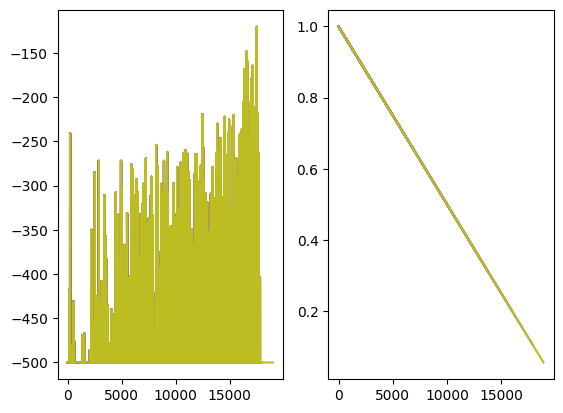

In [6]:
acrobot = AcrobotDQN()
acrobot.train(episodes=20000)

In [7]:
acrobot.test(episodes=3, model_filepath='acrobot_dql_17496.pt')  # Test the learned policy

/home/gian/.pyenv/versions/jenv/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [11]:
## improved version

class DQN(nn.Module):
    def __init__(self, in_states, h1_nodes, h2_nodes, out_actions):
        super().__init__()

        self.fc1 = nn.Linear(in_states, h1_nodes)
        self.fc2 = nn.Linear(h1_nodes, h2_nodes)
        self.out = nn.Linear(h2_nodes, out_actions)

    def forward(self, x):
        return self.out(F.relu(self.fc2(F.relu(self.fc1(x)))))

In [53]:
class SumTree():
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1, dtype=np.float32)
        self.data_pointer = 0
    
    def update(self, idx, priority):
        tree_index = idx + self.capacity - 1
        change = priority - self.tree[tree_index]
        self.tree[tree_index] = priority
        while tree_index != 0:
            tree_index = (tree_index - 1) // 2
            self.tree[tree_index] += change
        
    def get_leaf(self, idx):
        parent_index = 0
        while True:
            left_child = 2 * parent_index + 1
            right_child = left_child + 1

            if left_child >= len(self.tree):
                leaf_index = parent_index
                break
            if idx <= self.tree[left_child]:
                parent_index = left_child
            else:
                idx -= self.tree[left_child]
                parent_index = right_child
        data_index = leaf_index - self.capacity + 1
        return data_index, self.tree[leaf_index]
    
    def total_sum(self):
        return self.tree[0]

In [54]:
class PrioritizedReplayMemory():
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha  # alpha = 0.6 (controls how much prioritization is used) 0 = no prioritization, 1 = full prioritization
        self.priorities = SumTree(capacity)
        self.buffer = []
        self.position = 0
        self.max_priority = 1.0
        
    def store(self, state, action, reward, next_state, done, priority):
        experience = (state, action, reward, next_state, done)
        
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
            current_index = len(self.buffer) - 1
            self.priorities.update(current_index, priority ** self.alpha)
        else:
            self.buffer[self.position] = experience
            self.priorities.update(self.position, priority ** self.alpha)
            self.position = (self.position + 1) % self.capacity
        self.max_priority = max(self.max_priority, priority)

    def update_priority(self, index, priority):
        self.priorities.update(index, priority ** self.alpha)
        self.max_priority = max(self.max_priority, priority)
    
    def sample(self, batch_size, beta=0.4):
        indices = []
        priorities = []
        experiences = []

        # sample based on priority
        total_priority = self.priorities.total_sum()
        segment_size = total_priority / batch_size

        for i in range(batch_size):
            a = segment_size * i
            b = segment_size * (i + 1)
            value = random.uniform(a, b)

            index, priority = self.priorities.get_leaf(value)
            #if index >= len(self.buffer):
            #    index = len(self.buffer) - 1
            indices.append(index)
            priorities.append(priority)
            experiences.append(self.buffer[index])

        # calculate importance sampling weights
        weights = []
        min_prob = min(priorities) / total_priority
        max_weight = (min_prob * len(self.buffer)) ** (-beta)

        for priority in priorities:
            prob = priority / total_priority
            weight = (prob * len(self.buffer)) ** (-beta)
            weights.append(weight / max_weight)
        
        return experiences, indices, weights

    def get_max_priority(self):
        return self.max_priority

    def __len__(self):
        return len(self.buffer)

In [60]:
class AcrobotDQN():
    learning_rate_a = 0.0005
    discount_factor_g = 0.99  ## gamma
    network_sync_rate = 4_000 # between 1,000 to 20,000 steps
    replay_memory_size = 100_000
    mini_batch_size = 32
    num_divisions = 100
    epsilon_start = 1
    epsilon_end = 0.01
    epsilon_decay = 0.995
    network_layers = [128, 128]

    loss_fn = nn.MSELoss()
    optimizer = None
    memory = None
    device = None


    def train(self, episodes, device='cpu'):
        env = gym.make('Acrobot-v1')
        num_states = env.observation_space.shape[0]
        num_actions = env.action_space.n

        self.cos_th_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], self.num_divisions)
        self.sin_th_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], self.num_divisions)
        self.cos_th2_space = np.linspace(env.observation_space.low[2], env.observation_space.high[2], self.num_divisions)
        self.sin_th2_space = np.linspace(env.observation_space.low[3], env.observation_space.high[3], self.num_divisions)
        self.vel_th_space = np.linspace(env.observation_space.low[4], env.observation_space.high[4], self.num_divisions)
        self.vel_th2_space = np.linspace(env.observation_space.low[5], env.observation_space.high[5], self.num_divisions)

        epsilon = self.epsilon_start
        self.memory = PrioritizedReplayMemory(self.replay_memory_size)
        policy_dqn = DQN(num_states, self.network_layers[0], self.network_layers[1], num_actions).to(device)
        target_dqn = DQN(num_states, self.network_layers[0], self.network_layers[1], num_actions).to(device)

        target_dqn.load_state_dict(policy_dqn.state_dict())

        self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.learning_rate_a)
        self.device = device
        rewards_per_episode = []

        epsilon_history = []

        step_count=0
        goal_reached=False
        best_rewards=-200

        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0
            terminated = False      # True when agent reached goal
            truncated = False      # True when agent reached max steps

            rewards = 0

            while not (terminated or truncated):
                if random.random() < epsilon:
                    # select random action
                    action = env.action_space.sample() # actions: 0=left,1=idle,2=right
                else:
                    # select best action            
                    with torch.no_grad():
                        action = policy_dqn(self.state_to_dqn_input(state)).argmax().item()
                new_state,reward,terminated,truncated,_ = env.step(action)
                rewards += reward
                max_priority = self.memory.get_max_priority()
                if max_priority == 0:  # if memory is empty, set max_priority to 1.0
                    max_priority = 1.0
                self.memory.store(state, action, reward, new_state, terminated, max_priority)
                state = new_state
                step_count+=1

            rewards_per_episode.append(rewards)
            if(terminated):
                goal_reached = True

            # Graph training progress
            if(i!=0 and i%1000==0):
                print(f'Episode {i} Epsilon {epsilon}')
                self.plot_progress(rewards_per_episode, epsilon_history)

            if rewards>best_rewards:
                best_rewards = rewards
                print(f'Best rewards so far: {best_rewards}')
                # Save policy
                torch.save(policy_dqn.state_dict(), f"acrobot_dql_{i}.pt")

            if len(self.memory)>self.mini_batch_size and goal_reached:
                mini_batch, indices, weights = self.memory.sample(self.mini_batch_size)

                self.optimize(mini_batch, indices, weights, policy_dqn, target_dqn)        

                # Decay epsilon
                epsilon = max(epsilon * self.epsilon_decay, self.epsilon_end)
                epsilon_history.append(epsilon)

                # Copy policy network to target network after a certain number of steps
                if step_count > self.network_sync_rate:
                    target_dqn.load_state_dict(policy_dqn.state_dict())
                    step_count=0  

    def state_to_dqn_input(self, state)->torch.Tensor:
        state_1 = np.digitize(state[0], self.cos_th_space)
        state_2 = np.digitize(state[1], self.sin_th_space)
        state_3 = np.digitize(state[2], self.cos_th2_space)
        state_4 = np.digitize(state[3], self.sin_th2_space)
        state_5 = np.digitize(state[4], self.vel_th_space)
        state_6 = np.digitize(state[5], self.vel_th2_space)
        return torch.tensor([state_1, state_2, state_3, state_4, state_5, state_6], dtype=torch.float32).to(self.device)

    def optimize(self, mini_batch, indices, weights, policy_dqn, target_dqn):

        current_q_list = []
        target_q_list = []
        td_errors = []

        for state, action, reward, new_state, terminated in mini_batch:
            if terminated: 
                target = torch.tensor([reward], dtype=torch.float32).to(self.device)
            else:
                with torch.no_grad():
                    target = (reward + self.discount_factor_g * target_dqn(self.state_to_dqn_input(new_state)).max())

            # Get the current set of Q values
            current_q = policy_dqn(self.state_to_dqn_input(state))
            current_q_list.append(current_q)

            # Get the target set of Q values
            target_q = target_dqn(self.state_to_dqn_input(state)) 
            # Adjust the specific action to the target that was just calculated
            target_q[action] = target
            target_q_list.append(target_q)

            # Calculate TD error
            td_error = target - current_q[action]
            td_errors.append(td_error.item())

        # Compute loss for the whole minibatch
        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        # Apply importance sampling weights
        weights = torch.tensor(weights, dtype=torch.float32).to(self.device)
        loss = (loss * weights).mean()
        

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update priorities in the replay memory
        for idx, td_error in zip(indices, td_errors):
            priority = abs(td_error) + 1e-5
            self.memory.update_priority(idx, priority)

    def plot_progress(self, rewards_per_episode, epsilon_history):
        # Create new graph 
        plt.figure(1)

        # Plot average rewards (Y-axis) vs episodes (X-axis)
        # rewards_curve = np.zeros(len(rewards_per_episode))
        # for x in range(len(rewards_per_episode)):
            # rewards_curve[x] = np.min(rewards_per_episode[max(0, x-10):(x+1)])
        plt.subplot(121) # plot on a 1 row x 2 col grid, at cell 1
        # plt.plot(sum_rewards)
        plt.plot(rewards_per_episode)
        
        # Plot epsilon decay (Y-axis) vs episodes (X-axis)
        plt.subplot(122) # plot on a 1 row x 2 col grid, at cell 2
        plt.plot(epsilon_history)
        plt.savefig('acrobot_dql.png')

    # Run the environment with the learned policy
    def test(self, episodes, model_filepath):
        # Create FrozenLake instance
        env = gym.make('Acrobot-v1', render_mode='human')
        num_states = env.observation_space.shape[0]
        num_actions = env.action_space.n

        self.cos_th_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], self.num_divisions)
        self.sin_th_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], self.num_divisions)
        self.cos_th2_space = np.linspace(env.observation_space.low[2], env.observation_space.high[2], self.num_divisions)
        self.sin_th2_space = np.linspace(env.observation_space.low[3], env.observation_space.high[3], self.num_divisions)
        self.vel_th_space = np.linspace(env.observation_space.low[4], env.observation_space.high[4], self.num_divisions)
        self.vel_th2_space = np.linspace(env.observation_space.low[5], env.observation_space.high[5], self.num_divisions)

        # Load learned policy
        policy_dqn = DQN(num_states, self.network_layers[0], self.network_layers[1], num_actions)
        policy_dqn.load_state_dict(torch.load(model_filepath))
        policy_dqn.eval()    # switch model to evaluation mode

        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal
            truncated = False       # True when agent takes more than 200 actions            

            # Agent navigates map until it falls into a hole (terminated), reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and not truncated):  
                # Select best action   
                with torch.no_grad():
                    action = policy_dqn(self.state_to_dqn_input(state)).argmax().item()

                # Execute action
                state,reward,terminated,truncated,_ = env.step(action)

        env.close()

Best rewards so far: -135.0
Episode 1000 Epsilon 0.01
Episode 2000 Epsilon 0.01
Best rewards so far: -123.0
Episode 3000 Epsilon 0.01
Episode 4000 Epsilon 0.01
Best rewards so far: -114.0
Best rewards so far: -110.0
Best rewards so far: -105.0
Best rewards so far: -99.0
Best rewards so far: -90.0
Training completed in: 0:10:40.293794
Best rewards so far: -160.0
Best rewards so far: -133.0
Best rewards so far: -129.0
Best rewards so far: -123.0
Episode 1000 Epsilon 0.01
Best rewards so far: -120.0
Best rewards so far: -115.0
Episode 2000 Epsilon 0.01
Best rewards so far: -104.0
Best rewards so far: -103.0
Best rewards so far: -100.0
Best rewards so far: -99.0
Best rewards so far: -95.0
Best rewards so far: -87.0
Best rewards so far: -85.0
Best rewards so far: -79.0
Best rewards so far: -73.0
Episode 3000 Epsilon 0.01
Best rewards so far: -67.0
Episode 4000 Epsilon 0.01
Best rewards so far: -64.0
Best rewards so far: -63.0
Training completed in: 0:13:10.264083


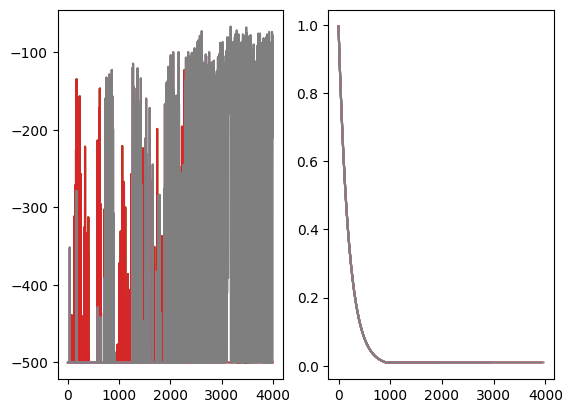

In [56]:
start = datetime.now()
acrobot = AcrobotDQN()
acrobot.train(episodes=5_000, device='cpu')
print(f'Training completed in: {datetime.now() - start}')
start = datetime.now()
acrobot.train(episodes=5_000, device='cuda')
print(f'Training completed in: {datetime.now() - start}')

In [61]:
acrobot = AcrobotDQN()
acrobot.test(episodes=3, model_filepath='acrobot_dql_4764.pt')  # Test the learned policy

/home/gian/.pyenv/versions/jenv/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists
